# Detección de Agujeros en Containers

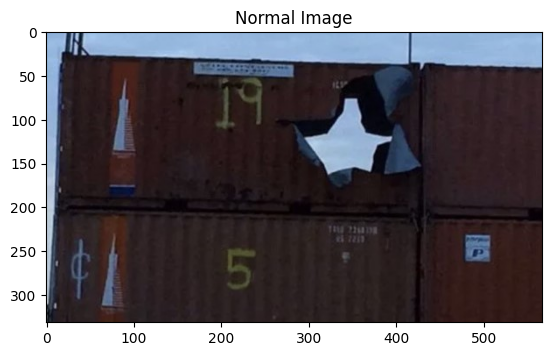

In [1]:
# Importing necessary libraries
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np

# URL del archivo de imagen en formato raw de GitHub
dir_url_base = 'https://raw.githubusercontent.com/JuanZapa7a/JoseAndres/main/images/'
image = 'foto28.jpg'
image_url = dir_url_base + image

container = imread(image_url)
plt.imshow(container)
plt.title('Normal Image')
plt.show()


The next step is convert the image in a gray image.

Text(0.5, 1.0, 'Gray')

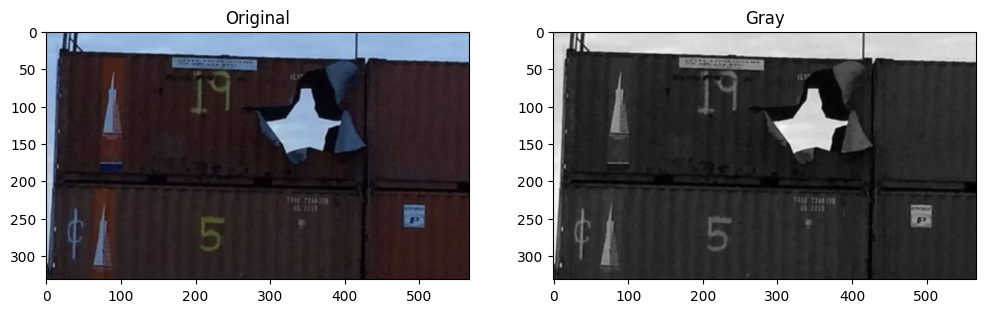

In [2]:
from skimage.color import rgb2gray

# To gray
gray_container = rgb2gray(container)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(container)
ax[0].set_title('Original')
ax[1].imshow(gray_container, cmap='gray')
ax[1].set_title('Gray')


Next, we need to obtain a binarized image using a threshold value.

0.40399017003676474


Text(0.5, 1.0, 'Gray')

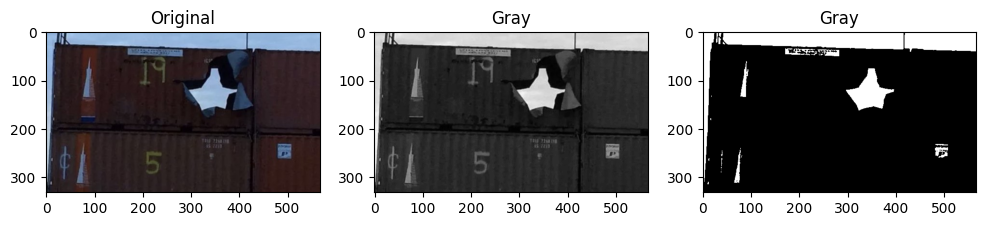

In [3]:
from skimage import filters

# Computing Otsu's thresholding value
threshold = filters.threshold_otsu(gray_container)
print(threshold)

# Binarized image
thresh_gray_container = (gray_container > threshold)*1

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(container)
ax[0].set_title('Original')
ax[1].imshow(gray_container, cmap='gray')
ax[1].set_title('Gray')
ax[2].imshow(thresh_gray_container, cmap='gray')
ax[2].set_title('Gray')


Next, now we must clean the data. For that, we use ditations and erosions.

Text(0.5, 1.0, 'Clearer border')

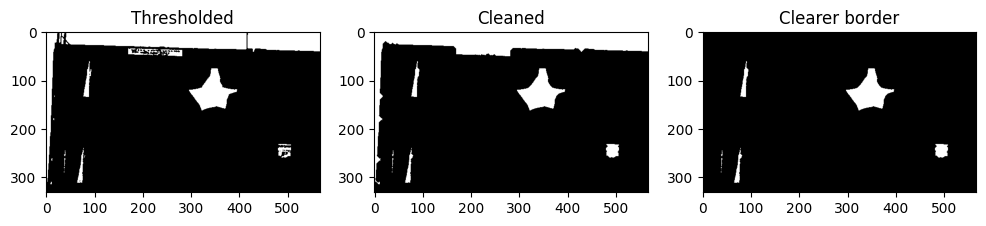

In [4]:
from skimage import morphology
from skimage.segmentation import clear_border


def multi_dil(im, num):
    for i in range(num):
        im = morphology.binary_dilation(im)
    return im


def multi_ero(im, num):
    for i in range(num):
        im = morphology.binary_erosion(im)
    return im

# We use this chain operation to clean the image:


container_cleaned = multi_ero(multi_dil(thresh_gray_container, 5), 5)


# remove artifacts connected to image border
container_cleared = clear_border(container_cleaned)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(thresh_gray_container, cmap='gray')
ax[0].set_title('Thresholded')
ax[1].imshow(container_cleaned, cmap='gray')
ax[1].set_title('Cleaned')
ax[2].imshow(container_cleared, cmap='gray')
ax[2].set_title('Clearer border')


Next, and now that this is relatively clean, let us get the labels and properties of this last image!

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


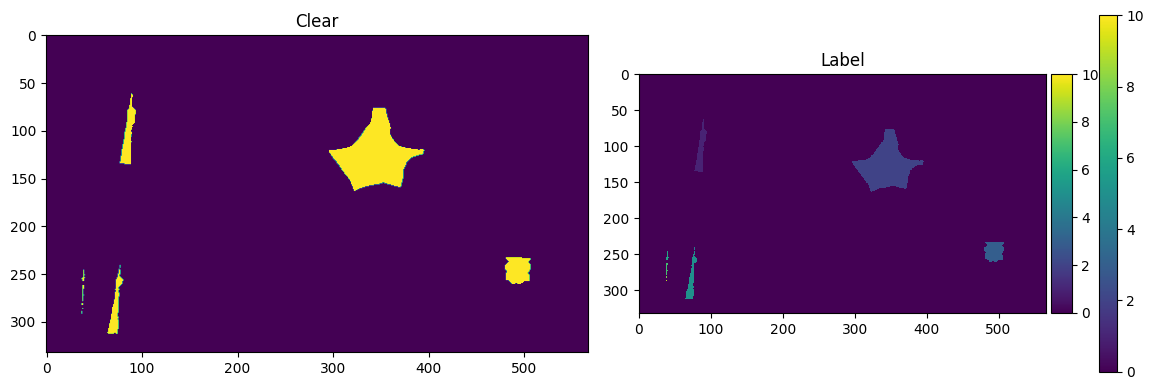

In [5]:
from skimage.measure import label

label_container = label(container_cleared)

#imshow(label_container, vmin=np.amin(label_container), vmax=np.amax(label_container))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(container_cleared)
ax[0].set_title('Clear')

ax[1].imshow(label_container)
ax[1].set_title('Label')

fig.colorbar(imshow(label_container), ax=ax[1])
fig.tight_layout()

There are a lot of features that can be extracted from this labelled image. To mention a few we have:

Now, let’s use regionprops and look at the following properties:

  1. area
  2. perimeter
  3. bbox — bounding box dimensions
  4. bbox_area — area of bounding box
  5. centroid — coordinate of centroid
  6. convex_image — convex hull of the blob
  7. convex_area — area of the convex hull
  8. eccentricity — measure how it fits into an ellipse (0) for circles (how elongated is your object)
  9. major_axis_length — length of the major moment of the ellipse fitted
  10. minor_axis_length — length of the minor moment of the ellipse fitted

Let us try to take the area of the bigger area object:

In [6]:
from skimage.measure import regionprops


props=regionprops(label_container)

print(len(props))

for i in range(len(props)):
  print(i)
  print(props[i].area) #area (zero) 0th object in the image
  print(props[i].bbox)


10
0
535.0
(62, 77, 136, 94)
1
3978.0
(77, 296, 164, 396)
2
646.0
(233, 480, 261, 507)
3
3.0
(241, 77, 244, 78)
4
416.0
(245, 64, 313, 81)
5
19.0
(246, 37, 258, 41)
6
22.0
(262, 38, 279, 40)
7
4.0
(281, 37, 283, 39)
8
1.0
(286, 38, 287, 39)
9
3.0
(289, 37, 292, 38)



Now, I can calculate the bigger area in the image. But I want to see some statistics from objects earlier.

In [7]:
from skimage.measure import regionprops_table
import pandas as pd


stats = regionprops_table(label_container,
                          properties=('centroid', 'area', 'bbox'))


pd.DataFrame(stats)

,centroid-0,centroid-1,area,bbox-0,bbox-1,bbox-2,bbox-3
0,105.689720,85.633645,535.0,62,77,136,94
1,126.394419,343.692810,3978.0,77,296,164,396
2,245.893189,493.030960,646.0,233,480,261,507
3,242.000000,77.000000,3.0,241,77,244,78
4,285.420673,72.372596,416.0,245,64,313,81
5,252.631579,38.789474,19.0,246,37,258,41
6,268.909091,38.227273,22.0,262,38,279,40
7,281.500000,37.500000,4.0,281,37,283,39
8,286.000000,38.000000,1.0,286,38,287,39
9,290.000000,37.000000,3.0,289,37,292,38


First af all, i want to have all data about the main feature which is very significative for that object. In this case area.

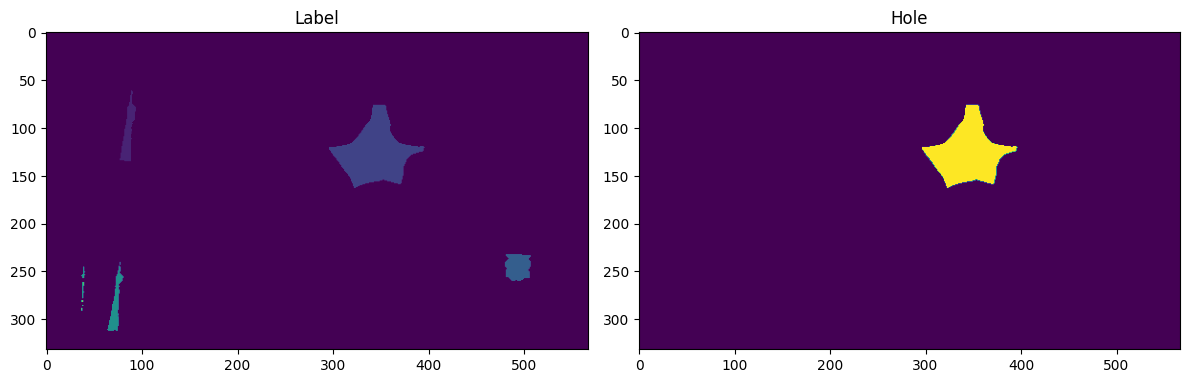

In [8]:
onlyArea = [props[i].area for i in range (len(props))]

# With index_ob we can obtain any feature of the object (our hole) using
# props[index_ob].feature
index_ob = onlyArea.index(max(onlyArea))

# labels is 1 from N but index is from 0 to N-1.
hole_container = label_container == index_ob+1

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(label_container)
ax[0].set_title('Label')

ax[1].imshow(hole_container)
ax[1].set_title('Hole')

#fig.colorbar(imshow(label_container), ax=ax[1])
fig.tight_layout()

Finally, I only have that draw the segmented object on the original figure (in gray for contrast)

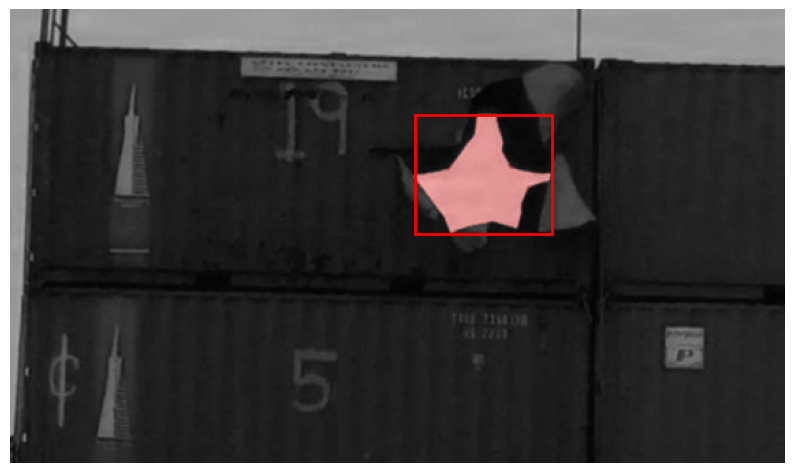

In [9]:
from skimage.color import label2rgb
import matplotlib.patches as mpatches

# label image regions
label_image = label(hole_container)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=container, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
ax.set_axis_off()

minr, minc, maxr, maxc = props[index_ob].bbox
rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)
